In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [2]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=1.5))

In [4]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 0s 3ms/step - loss: 0.6208
Epoch 2/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0914
Epoch 3/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0627
Epoch 4/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0569
Epoch 5/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0540
Epoch 6/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0374
Epoch 7/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0309
Epoch 8/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0234
Epoch 9/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 10/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 11/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 12/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0072
Epoch 13/20
2/2 [==============================] - 0s 2ms/step - loss: 0.

In [5]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 1ms/step


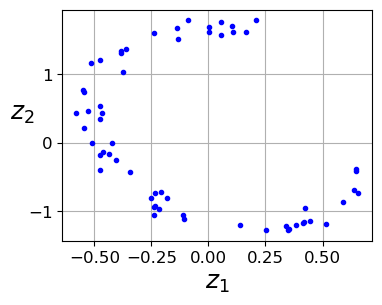

In [6]:
fig = plt.figure(figsize=(4, 3))
plt.plot(codings[:,0], codings[:,1], 'b.')
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
plt.grid(True)

In [7]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [8]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [9]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss='binary_crossentropy',
                   optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3366 - rounded_accuracy: 0.8885 - val_loss: 0.3096 - val_rounded_accuracy: 0.9130
Epoch 2/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3042 - rounded_accuracy: 0.9164 - val_loss: 0.3013 - val_rounded_accuracy: 0.9208
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2973 - rounded_accuracy: 0.9227 - val_loss: 0.2956 - val_rounded_accuracy: 0.9251
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2931 - rounded_accuracy: 0.9266 - val_loss: 0.2925 - val_rounded_accuracy: 0.9288
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2903 - rounded_accuracy: 0.9292 - val_loss: 0.2906 - val_rounded_accuracy: 0.9295
Epoch 6/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2884 - rounded_accuracy: 0.9309 - val_loss: 0.2886 - val_rounded_accuracy: 0.9317
Epoch 7/20
1719/1719 [==================

In [10]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [11]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 38ms/step


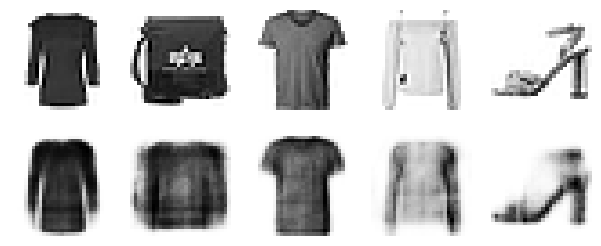

In [12]:
show_reconstructions(stacked_ae)

In [13]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

157/157 [==============================] - 0s 407us/step


(-0.04956735074520111,
 1.0409143656492232,
 0.026224046200513836,
 1.0463702835142612)

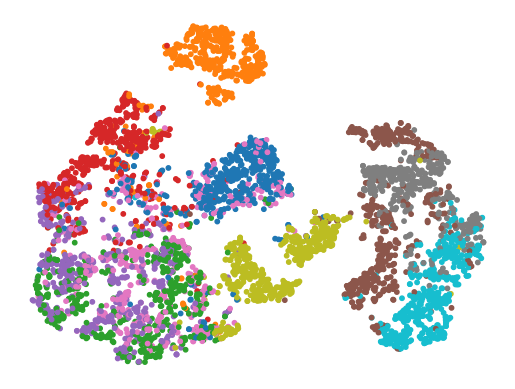

In [14]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap='tab10')
plt.axis('off')

(-0.04956735074520111,
 1.0409143656492232,
 0.026224046200513836,
 1.0463702835142612)

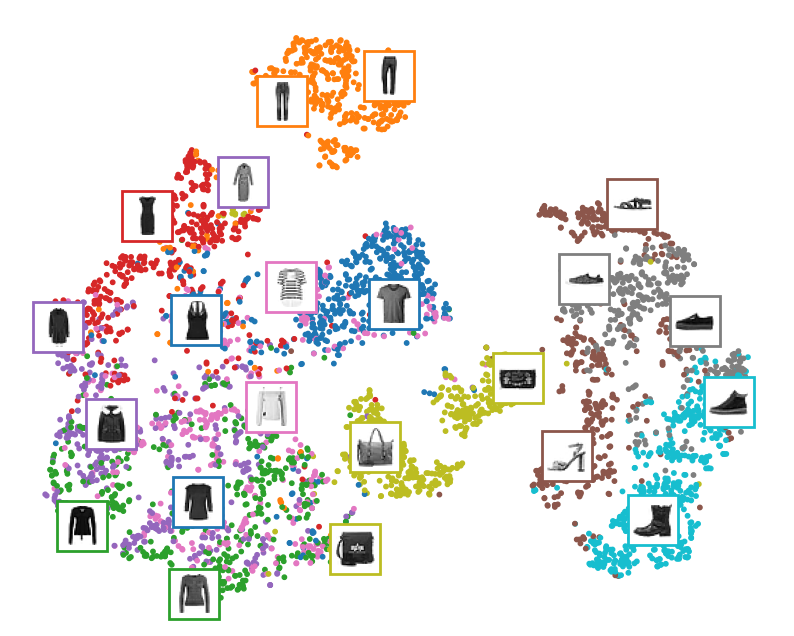

In [15]:
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_position = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_position) ** 2, axis=1)
    if np.min(dist) > 0.02:
        image_position = np.r_[image_position, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap='binary'),
            position, bboxprops={'edgecolor': cmap(y_valid[index]), 'lw': 2}
        )
        plt.gca().add_artist(imagebox)
plt.axis('off')

In [16]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias',
                                      shape=[self.dense.input_shape[-1]],
                                      initializer='zeros')
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation='selu')
dense_2 = keras.layers.Dense(30, activation='selu')

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation='selu'),
    DenseTranspose(dense_1, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3274 - rounded_accuracy: 0.8953 - val_loss: 0.3046 - val_rounded_accuracy: 0.9136
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2976 - rounded_accuracy: 0.9220 - val_loss: 0.2944 - val_rounded_accuracy: 0.9275
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2913 - rounded_accuracy: 0.9279 - val_loss: 0.3009 - val_rounded_accuracy: 0.9088
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2882 - rounded_accuracy: 0.9309 - val_loss: 0.2901 - val_rounded_accuracy: 0.9329
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2862 - rounded_accuracy: 0.9327 - val_loss: 0.2868 - val_rounded_accuracy: 0.9322
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2849 - rounded_accuracy: 0.9340 - val_loss: 0.2850 - val_rounded_accuracy: 0.9353
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 36ms/step


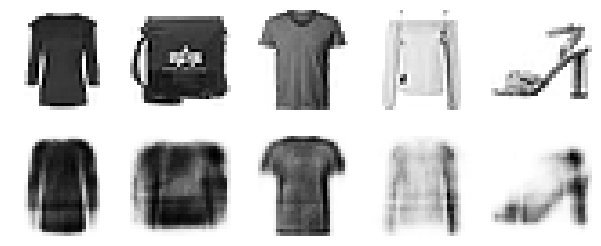

In [18]:
show_reconstructions(tied_ae)

In [19]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation='selu', input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [20]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, 'binary_crossentropy',
    keras.optimizers.SGD(learning_rate=1.5), output_activation='sigmoid',
    metrics=[rounded_accuracy]
)
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, 'mse', keras.optimizers.SGD(learning_rate=0.05),
    output_activation='selu'
)

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3444 - rounded_accuracy: 0.8875 - val_loss: 0.3113 - val_rounded_accuracy: 0.9157
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3028 - rounded_accuracy: 0.9214 - val_loss: 0.2996 - val_rounded_accuracy: 0.9256
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2940 - rounded_accuracy: 0.9295 - val_loss: 0.2926 - val_rounded_accuracy: 0.9321
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2885 - rounded_accuracy: 0.9347 - val_loss: 0.2882 - val_rounded_accuracy: 0.9367
Epoch 5/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.2848 - rounded_accuracy: 0.9383 - val_loss: 0.2852 - val_rounded_accuracy: 0.9397
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2822 - rounded_accuracy: 0.9408 - val_loss: 0.2829 - val_rounded_accuracy: 0.9414
Epoch 7/10
1719/1719 [==================

Epoch 1/10
1719/1719 [==============================] - 1s 443us/step - loss: 0.5880 - val_loss: 0.4227
Epoch 2/10
1719/1719 [==============================] - 1s 414us/step - loss: 0.2619 - val_loss: 0.2356
Epoch 3/10
1719/1719 [==============================] - 1s 405us/step - loss: 0.2231 - val_loss: 0.2141
Epoch 4/10
1719/1719 [==============================] - 1s 402us/step - loss: 0.2042 - val_loss: 0.1937
Epoch 5/10
1719/1719 [==============================] - 1s 396us/step - loss: 0.1907 - val_loss: 0.1851
Epoch 6/10
1719/1719 [==============================] - 1s 393us/step - loss: 0.1845 - val_loss: 0.1821
Epoch 7/10
1719/1719 [==============================] - 1s 396us/step - loss: 0.1825 - val_loss: 0.1852
Epoch 8/10
1719/1719 [==============================] - 1s 404us/step - loss: 0.1799 - val_loss: 0.1817
Epoch 9/10
1719/1719 [==============================] - 1s 396us/step - loss: 0.1791 - val_loss: 0.1810
Epoch 10/10
1719/1719 [==============================] - 1s 395u

In [21]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

1/1 [==============================] - 0s 36ms/step


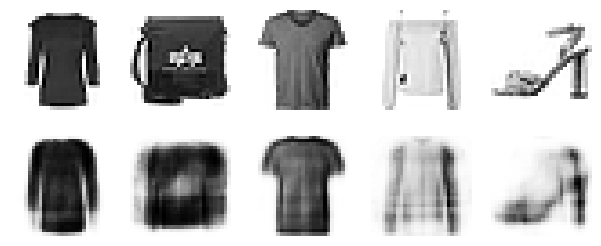

In [22]:
show_reconstructions(stacked_ae_1_by_1)

In [23]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='VALID', activation='selu',
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='SAME', activation='selu'),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='SAME', activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3006 - rounded_accuracy: 0.9200 - val_loss: 0.2827 - val_rounded_accuracy: 0.9373
Epoch 2/5
1719/1719 [==============================] - 18s 10ms/step - loss: 0.2756 - rounded_accuracy: 0.9416 - val_loss: 0.2731 - val_rounded_accuracy: 0.9450
Epoch 3/5
1719/1719 [==============================] - 19s 11ms/step - loss: 0.2708 - rounded_accuracy: 0.9462 - val_loss: 0.2697 - val_rounded_accuracy: 0.9496
Epoch 4/5
1719/1719 [==============================] - 20s 11ms/step - loss: 0.2683 - rounded_accuracy: 0.9488 - val_loss: 0.2698 - val_rounded_accuracy: 0.9467
Epoch 5/5
1719/1719 [==============================] - 842s 490ms/step - loss: 0.2666 - rounded_accuracy: 0.9508 - val_loss: 0.2665 - val_rounded_accuracy: 0.9519


In [24]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)        

1/1 [==============================] - 0s 72ms/step


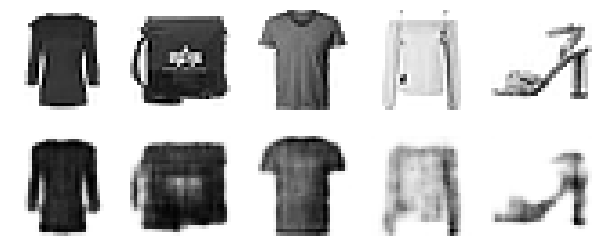

In [25]:
show_reconstructions(conv_ae)

In [26]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation='sigmoid'))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [27]:
# history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

In [28]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3566 - rounded_accuracy: 0.8707 - val_loss: 0.3206 - val_rounded_accuracy: 0.9041
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3189 - rounded_accuracy: 0.9027 - val_loss: 0.3120 - val_rounded_accuracy: 0.9108
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3128 - rounded_accuracy: 0.9075 - val_loss: 0.3069 - val_rounded_accuracy: 0.9149
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3089 - rounded_accuracy: 0.9106 - val_loss: 0.3037 - val_rounded_accuracy: 0.9186
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3063 - rounded_accuracy: 0.9128 - val_loss: 0.3014 - val_rounded_accuracy: 0.9200
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3044 - rounded_accuracy: 0.9143 - val_loss: 0.3003 - val_rounded_accuracy: 0.9191
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 37ms/step


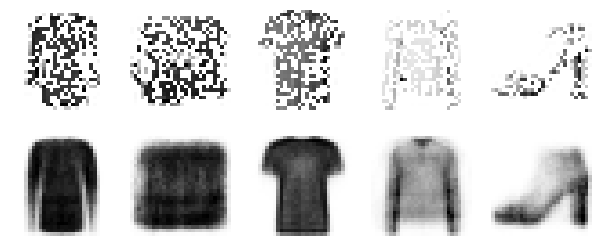

In [29]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))

In [30]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='sigmoid')
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4514 - rounded_accuracy: 0.7791 - val_loss: 0.3876 - val_rounded_accuracy: 0.8450
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3700 - rounded_accuracy: 0.8596 - val_loss: 0.3608 - val_rounded_accuracy: 0.8705
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3499 - rounded_accuracy: 0.8781 - val_loss: 0.3451 - val_rounded_accuracy: 0.8838
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3374 - rounded_accuracy: 0.8885 - val_loss: 0.3331 - val_rounded_accuracy: 0.8953
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3264 - rounded_accuracy: 0.8978 - val_loss: 0.3243 - val_rounded_accuracy: 0.9020
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3205 - rounded_accuracy: 0.9020 - val_loss: 0.3202 - val_rounded_accuracy: 0.9025
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 39ms/step


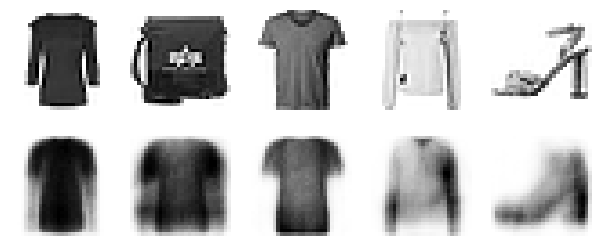

In [31]:
show_reconstructions(simple_ae)

In [32]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))
    ))
    ax.grid(True)

In [33]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], 'k--', label='Overall Mean = {:.2f}'.format(mean))
    ax1.legend(loc='upper center', fontsize=14)
    ax1.set_xlabel('Activation')
    ax1.set_ylabel('% Activations')
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], 'k--')
    ax2.set_xlabel('Neuron Mean Activation')
    ax2.set_ylabel('% Neurons')
    ax2.axis([0, 1, 0, height])

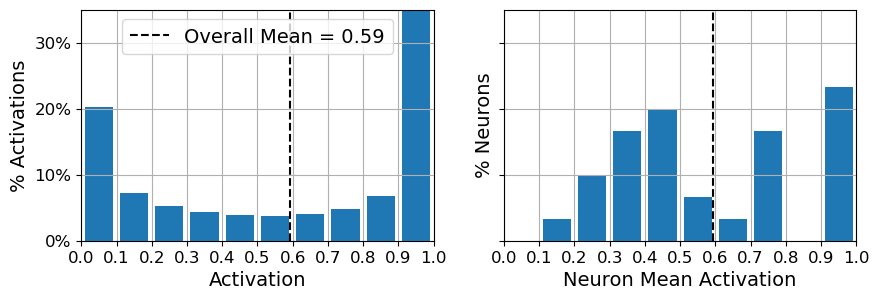

In [34]:
plot_activations_histogram(simple_encoder, height=0.35)

In [35]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(300, activation='sigmoid'),
    keras.layers.ActivityRegularization(l1=1e-3)
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[300]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4349 - rounded_accuracy: 0.8101 - val_loss: 0.3842 - val_rounded_accuracy: 0.8493
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3698 - rounded_accuracy: 0.8674 - val_loss: 0.3643 - val_rounded_accuracy: 0.8738
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3552 - rounded_accuracy: 0.8788 - val_loss: 0.3511 - val_rounded_accuracy: 0.8825
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3449 - rounded_accuracy: 0.8861 - val_loss: 0.3432 - val_rounded_accuracy: 0.8892
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3385 - rounded_accuracy: 0.8902 - val_loss: 0.3377 - val_rounded_accuracy: 0.8918
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3333 - rounded_accuracy: 0.8942 - val_loss: 0.3330 - val_rounded_accuracy: 0.8969
Epoch 7/10
1719/1719 [==================

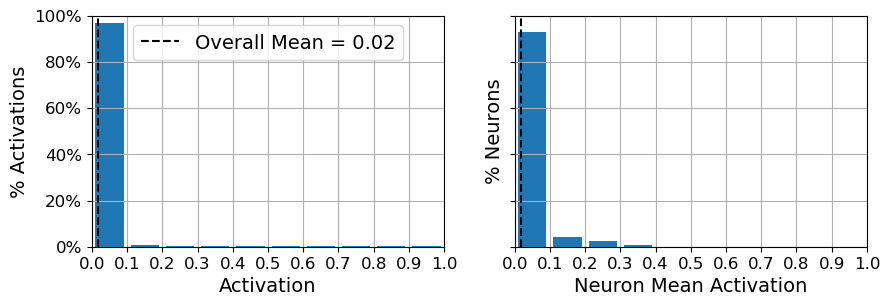

In [36]:
plot_activations_histogram(sparse_l1_encoder, height=1.)

In [37]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities)
        )

In [38]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(300, activation='sigmoid', activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[300]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4147 - rounded_accuracy: 0.8123 - val_loss: 0.3711 - val_rounded_accuracy: 0.8583
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3516 - rounded_accuracy: 0.8782 - val_loss: 0.3422 - val_rounded_accuracy: 0.8867
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3335 - rounded_accuracy: 0.8922 - val_loss: 0.3306 - val_rounded_accuracy: 0.8960
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3229 - rounded_accuracy: 0.9017 - val_loss: 0.3212 - val_rounded_accuracy: 0.9045
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3169 - rounded_accuracy: 0.9065 - val_loss: 0.3172 - val_rounded_accuracy: 0.9078
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3136 - rounded_accuracy: 0.9092 - val_loss: 0.3140 - val_rounded_accuracy: 0.9100
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 46ms/step


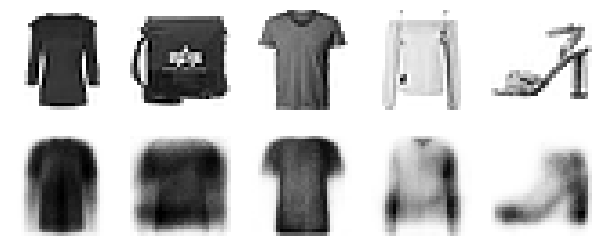

In [39]:
show_reconstructions(sparse_kl_ae)

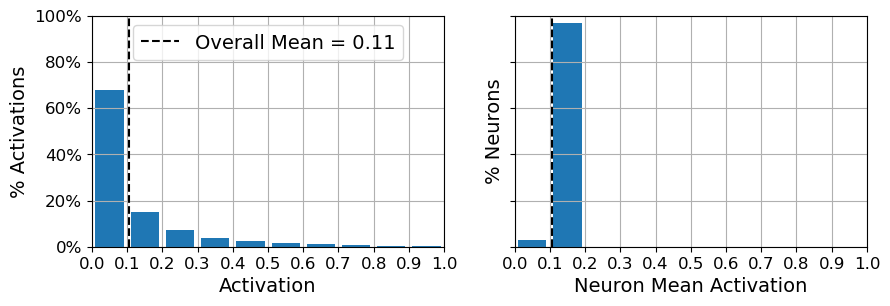

In [40]:
plot_activations_histogram(sparse_kl_encoder)

In [41]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [42]:
tf.random.set_seed(42)
np.random.seed(42)

coding_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation='selu')(z)
z = keras.layers.Dense(100, activation='selu')(z)
coding_mean = keras.layers.Dense(coding_size)(z)
coding_log_var = keras.layers.Dense(coding_size)(z)
codings = Sampling()([coding_mean, coding_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[coding_mean, coding_log_var, codings]
)

decoder_inputs = keras.layers.Input(shape=[coding_size])
x = keras.layers.Dense(100, activation='selu')(decoder_inputs)
x = keras.layers.Dense(150, activation='selu')(x)
x = keras.layers.Dense(28 * 28, activation='sigmoid')(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + coding_log_var - K.exp(coding_log_var) - K.square(coding_mean),
    axis=-1
)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3888 - rounded_accuracy: 0.8619 - val_loss: 0.3598 - val_rounded_accuracy: 0.8795
Epoch 2/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3425 - rounded_accuracy: 0.8980 - val_loss: 0.3338 - val_rounded_accuracy: 0.9069
Epoch 3/25
430/430 [==============================] - 4s 10ms/step - loss: 0.3321 - rounded_accuracy: 0.9056 - val_loss: 0.3286 - val_rounded_accuracy: 0.9093
Epoch 4/25
430/430 [==============================] - 4s 10ms/step - loss: 0.3270 - rounded_accuracy: 0.9099 - val_loss: 0.3272 - val_rounded_accuracy: 0.9117
Epoch 5/25
430/430 [==============================] - 4s 10ms/step - loss: 0.3237 - rounded_accuracy: 0.9126 - val_loss: 0.3259 - val_rounded_accuracy: 0.9112
Epoch 6/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3213 - rounded_accuracy: 0.9142 - val_loss: 0.3238 - val_rounded_accuracy: 0.9093
Epoch 7/25
430/430 [=============================

1/1 [==============================] - 0s 64ms/step


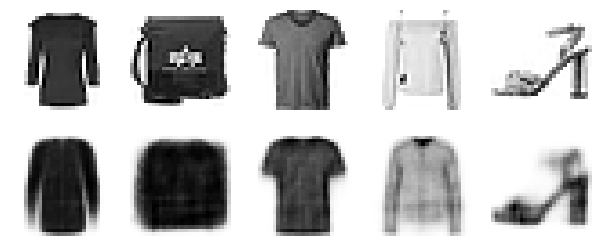

In [43]:
show_reconstructions(variational_ae)

In [44]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap='binary')
        plt.axis('off')

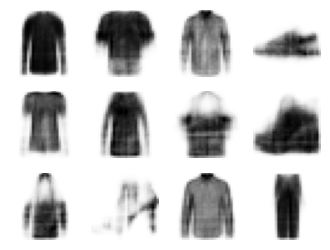

In [45]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, coding_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

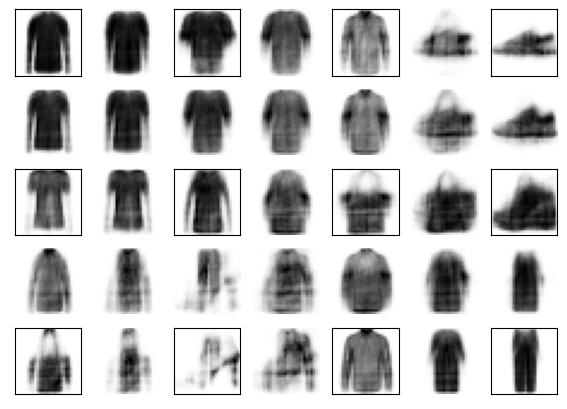

In [46]:
tf.random.set_seed(42)
np.random.seed(42)

coding_grid = tf.reshape(codings, [1, 3, 4, coding_size])
larger_grid = tf.image.resize(coding_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, coding_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index % 7 % 2 == 0 and index // 7 % 2 == 0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis('off')
    plt.imshow(image, cmap='binary')
    

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[codings_size]),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(1, activation='sigmoid')
])
gan = keras.models.Sequential([generator, discriminator])

In [48]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [49]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [50]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch + 1, n_epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)

Epoch 1/1


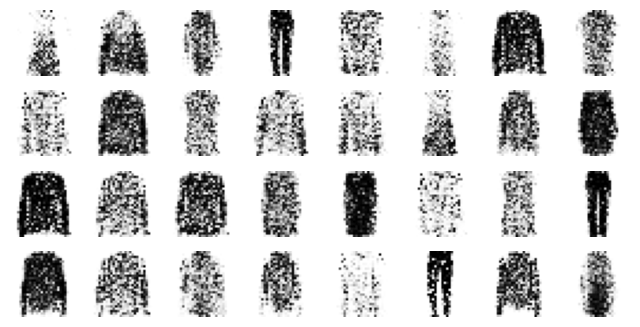

In [51]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

In [64]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='SAME',
                                 activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='SAME',
                                 activation='tanh')
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='SAME',
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='SAME',
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])
gan = keras.models.Sequential([generator, discriminator])

In [65]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [66]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [67]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/1


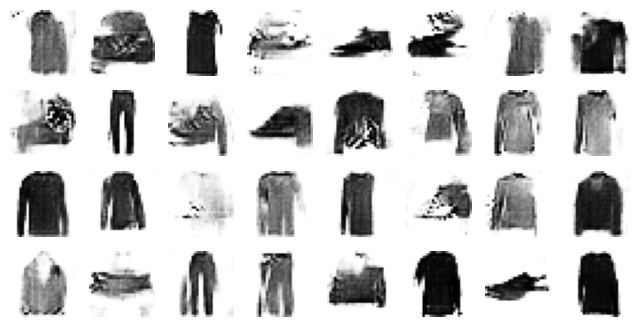

In [70]:
train_gan(gan, dataset, batch_size, codings_size, 1)

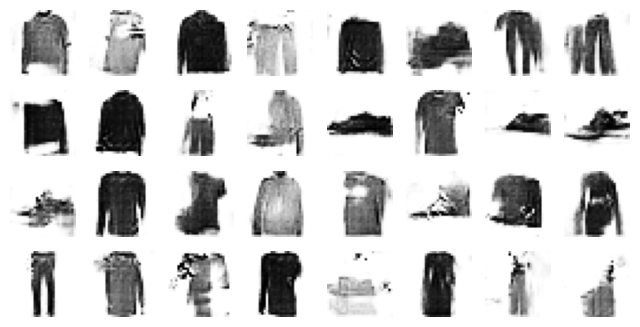

In [71]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)